# Assignment 7: The NICEst Assignment

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment7.html

In [ ]:
# imports you might need
import tensorflow as tf
tfkl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

from matplotlib import pyplot as plt
import numpy as np

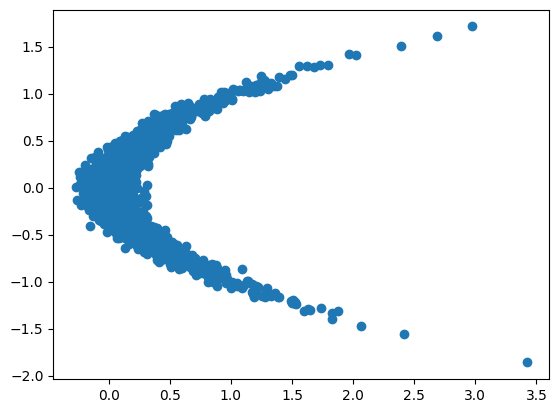

In [ ]:
# you can use x_samples as a toy dataset to train your first flow!
# remember, the model will need to learn to transform this "data distribution"
# into a chosen simple distribution (like standard normal).
n_samples = 2048
x2_dist = tfd.Normal(loc=0., scale=0.5)
x2_samples = x2_dist.sample(n_samples)
x1 = tfd.Normal(loc=1. * tf.square(x2_samples),
                scale=0.1*tf.ones(n_samples, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

as_np = x_samples.numpy()
plt.scatter(as_np[:, 0], as_np[:, 1])
a = plt.gca()
plt.show()

In [ ]:

# Define the NiceLayer class
class NiceLayer(tfkl.Layer):
    def __init__(self, transform_function, transform_part, **kwargs):
        super().__init__(**kwargs)
        self.transform_function = transform_function

        if transform_part not in ["one", "two"]:
            raise ValueError("transform_part must be 'one' or 'two', got {}".format(transform_part))
        self.transform_part = transform_part

    def call(self, inputs, training=None):
        return self.forward(inputs, training=training)

    def forward(self, x, training=None):
        x1, x2 = self.split_even_odd(x)
        if self.transform_part == "two":
            h1 = x1
            h2 = x2 + self.shift(x1, training=training)
        else:
            h1 = x1 + self.shift(x2, training=training)
            h2 = x2

        together = tf.concat([h1, h2], axis=-1)
        return tf.reshape(together, tf.shape(x))

    def backward(self, h, training=None):
        h1, h2 = self.split_even_odd(h)
        if self.transform_part == "two":
            x1 = h1
            x2 = h2 - self.shift(h1, training=training)
        else:
            x1 = h1 - self.shift(h2, training=training)
            x2 = h2

        together = tf.concat([x1, x2], axis=-1)
        return tf.reshape(together, tf.shape(h))

    def shift(self, input_part, training=None):
        return self.transform_function(input_part, training=training)

    def split_even_odd(self, inp):
        even = inp[:, 0::2]
        odd = inp[:, 1::2]
        return even, odd




Nice Class Before debugging

In [ ]:
# class Nice(tf.keras.Model):
#     def __init__(self, n_layers, layer_factory, base_distribution, scale=True, **kwargs):
#         super().__init__(**kwargs)
#         self.scale = scale
#         self.coupling_layers = []

#         transform_options = ["one", "two"]
#         for coupling_index in range(n_layers):
#             self.coupling_layers.append(NiceLayer(layer_factory(), transform_options[coupling_index % 2]))

#         self.base_distribution = base_distribution
#         self.scale_fn = tf.exp

#         self.nll_tracker = tf.keras.metrics.Mean("negative_log_likelihood")

#     def build(self, input_shape):
#         if self.scale:
#             self.scaler = tf.Variable(tf.zeros([1, input_shape[-1]]), name="scaler")

#     def call(self, inputs, training=None):
#         return self.forward(inputs, training=training)

#     def forward(self, x, training=None):
#         h = x
#         for layer in self.coupling_layers:
#             h = layer.forward(h, training=training)
#         if self.scale:
#             h = h * self.scale_fn(self.scaler)
#         return h

#     def backward(self, h, training=None):
#         x = h
#         if self.scale:
#             x = x / self.scale_fn(self.scaler)
#         for layer in reversed(self.coupling_layers):
#             x = layer.backward(x, training=training)
#         return x

#     def log_p(self, samples, training=None):
#         back_to_basics = self(samples, training=training)
#         if self.scale:
#             log_determinant = tf.reduce_sum(tf.math.log(self.scale_fn(self.scaler)))
#         else:
#             log_determinant = 0.0
#         return tf.reduce_sum(self.base_distribution.log_prob(back_to_basics), axis=1) + log_determinant

#     def train_step(self, data):
#         with tf.GradientTape() as tape:
#             nll = -tf.reduce_mean(self.log_p(data, training=True))

#         gradients = tape.gradient(nll, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

#         self.nll_tracker.update_state(nll)

#         return {"negative_log_likelihood": self.nll_tracker.result()}

#     def test_step(self, data):
#         nll = -tf.reduce_mean(self.log_p(data, training=False))

#         self.nll_tracker.update_state(nll)

#         return {"negative_log_likelihood": self.nll_tracker.result()}


#     def metrics(self):
#         return [self.nll_tracker]


In [ ]:
# Time for a sanity check!
input_dim = 2

# This network will be used for each coupling layer
def layer_factory():
    return tf.keras.Sequential([
        tfkl.Dense(64),
        tfkl.BatchNormalization(),
        tfkl.LeakyReLU(alpha=0.01),
        tfkl.Dense(input_dim // 2)
    ])

# Use Standard Normal base distribution
base_distribution = tfd.Normal(loc=tf.zeros((input_dim,)), scale=tf.ones((input_dim,)))
num_coupling_layers = 6
flow = Nice(num_coupling_layers, layer_factory, base_distribution, scale=True)
flow.build((None, input_dim))

# Draw samples from base distribution, map through backward, and again through its inversion forward
simple_samples = base_distribution.sample(n_samples)

test_generated = flow.backward(simple_samples)
simple_again = flow.forward(test_generated)

inversion_difference = (simple_samples - simple_again).numpy()

# This should be near 0
print('\nNear 0??')
print(inversion_difference.min(), inversion_difference.max())


Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)
Forward pass input shape: (2048, 2)
After layer 1 forward pass shape: (2048, 2)
After layer 2 forward pass shape: (2048, 2)
After layer 3 forward pass shape: (2048, 2)
After layer 4 forward pass shape: (2048, 2)
After layer 5 forward pass shape: (2048, 2)
After layer 6 forward pass shape: (2048, 2)
After scaling forward pass shape: (2048, 2)

Near 0??
-2.3841858e-07 2.3841858e-07


Yess, It is near 0!

Forward pass input shape: (2048, 2)
After layer 1 forward pass shape: (2048, 2)
After layer 2 forward pass shape: (2048, 2)
After layer 3 forward pass shape: (2048, 2)
After layer 4 forward pass shape: (2048, 2)
After layer 5 forward pass shape: (2048, 2)
After layer 6 forward pass shape: (2048, 2)
After scaling forward pass shape: (2048, 2)
Log probability shape: (2048,)
Forward pass input shape: (2048, 2)
After layer 1 forward pass shape: (2048, 2)
After layer 2 forward pass shape: (2048, 2)
After layer 3 forward pass shape: (2048, 2)
After layer 4 forward pass shape: (2048, 2)
After layer 5 forward pass shape: (2048, 2)
After layer 6 forward pass shape: (2048, 2)
After scaling forward pass shape: (2048, 2)
Log probability shape: (2048,)
0 tf.Tensor(3.6617851, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass sh

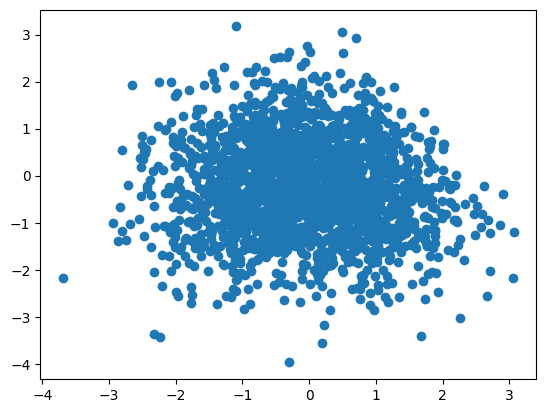

2500 tf.Tensor(1.4509223, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


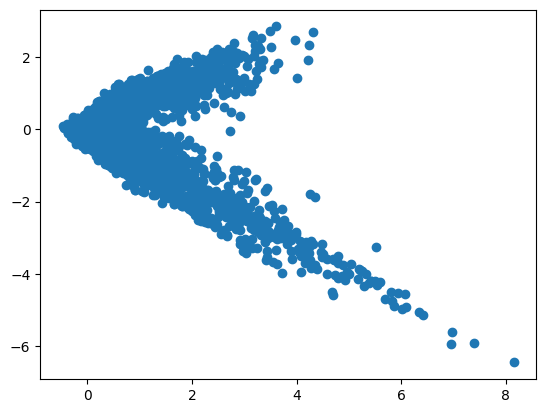

5000 tf.Tensor(1.0408309, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


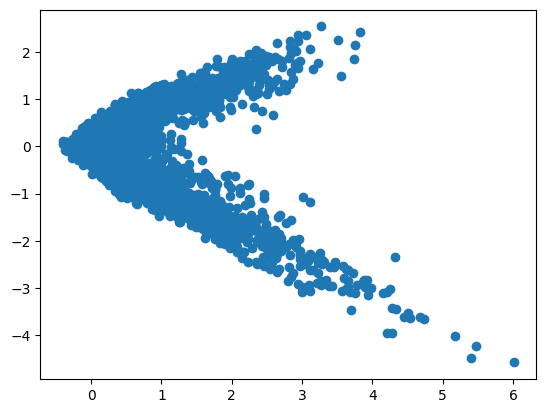

7500 tf.Tensor(0.6774379, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


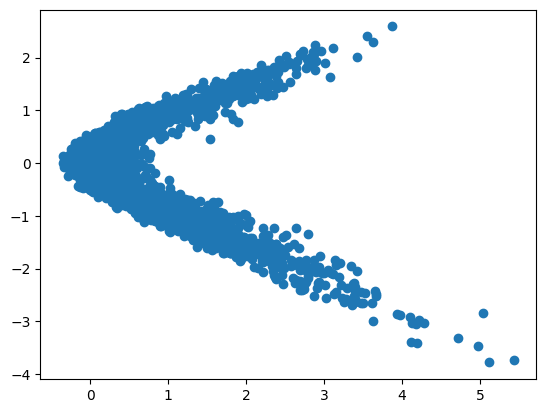

10000 tf.Tensor(0.40461215, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


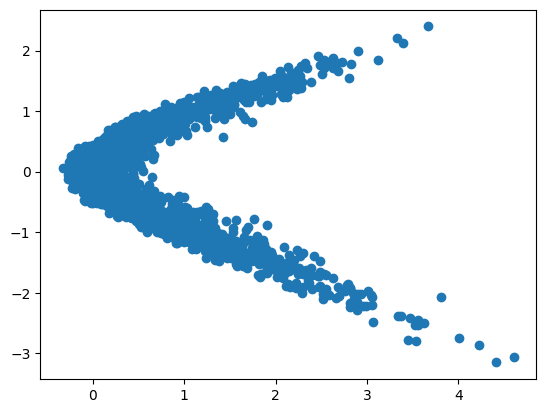

12500 tf.Tensor(0.21699995, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


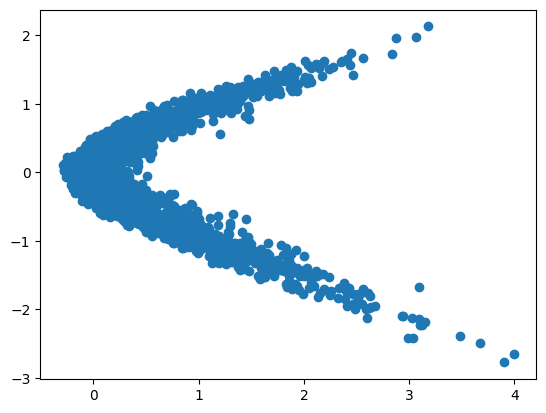

15000 tf.Tensor(0.09820551, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


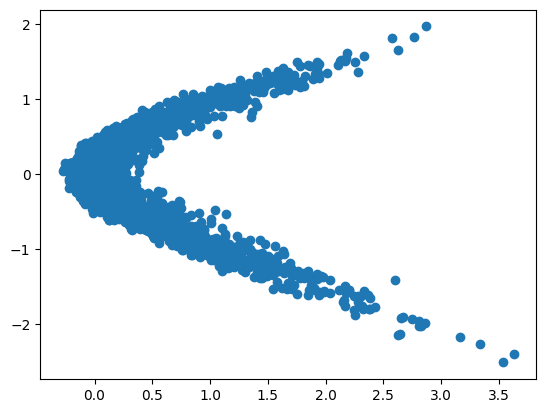

17500 tf.Tensor(0.030529477, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


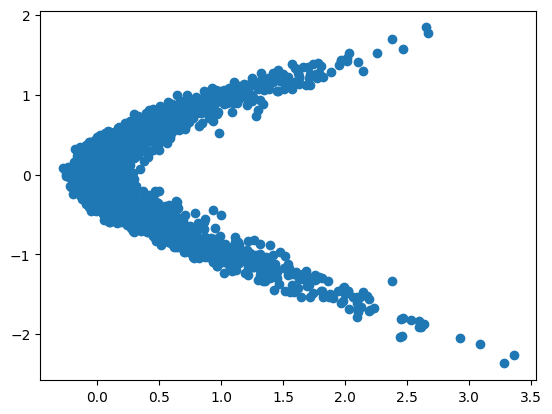

20000 tf.Tensor(-0.0027307253, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


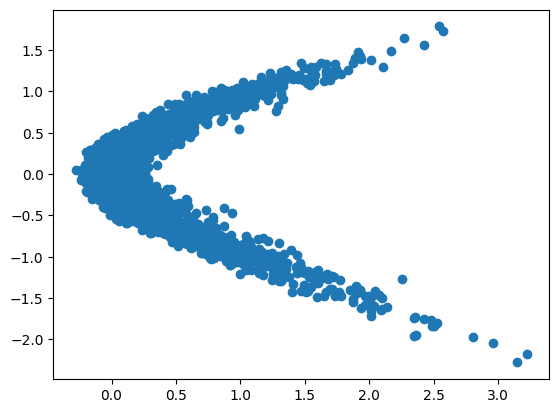

22500 tf.Tensor(-0.014937964, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


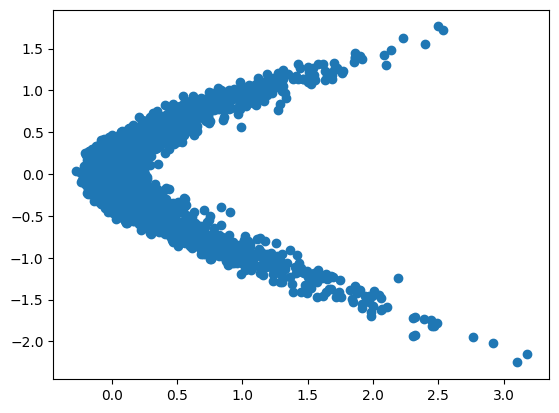

25000 tf.Tensor(-0.016707517, shape=(), dtype=float32)
Backward pass input shape: (2048, 2)
After scaling backward pass shape: (2048, 2)
After layer 6 backward pass shape: (2048, 2)
After layer 5 backward pass shape: (2048, 2)
After layer 4 backward pass shape: (2048, 2)
After layer 3 backward pass shape: (2048, 2)
After layer 2 backward pass shape: (2048, 2)
After layer 1 backward pass shape: (2048, 2)


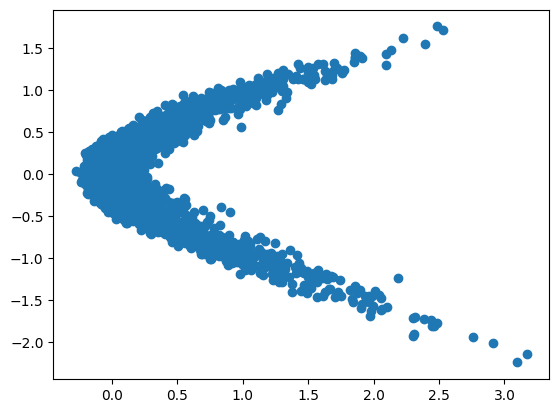

In [ ]:

# Training the model
@tf.function(jit_compile=True)
def train(batch):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(flow.log_p(batch, training=True))
    gradients = tape.gradient(loss, flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow.trainable_variables))
    return loss

train_steps = 25001
lr_fn = tf.optimizers.schedules.CosineDecay(1e-4, train_steps)
optimizer = tf.optimizers.Adam(lr_fn)
for step in range(train_steps):
    nll = train(x_samples)
    if not step % 2500:
        print(step, nll)
        current_samples = flow.backward(simple_samples).numpy()
        plt.scatter(current_samples[:, 0], current_samples[:, 1])
        plt.show()


Debugging nice class

In [ ]:
class Nice(tf.keras.Model):
    def __init__(self, n_layers, layer_factory, base_distribution, scale=True, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.coupling_layers = []

        transform_options = ["one", "two"]
        for coupling_index in range(n_layers):
            self.coupling_layers.append(NiceLayer(layer_factory(), transform_options[coupling_index % 2]))

        self.base_distribution = base_distribution
        self.scale_fn = tf.exp

        self.nll_tracker = tf.keras.metrics.Mean("negative_log_likelihood")

    def build(self, input_shape):
        if self.scale:
            self.scaler = tf.Variable(tf.zeros([1, input_shape[-1]]), name="scaler")

    def call(self, inputs, training=None):
        return self.forward(inputs, training=training)

    def forward(self, x, training=None):
        h = x
        print("Forward pass input shape:", x.shape)
        for i, layer in enumerate(self.coupling_layers):
            h = layer.forward(h, training=training)
            print(f"After layer {i + 1} forward pass shape:", h.shape)
        if self.scale:
            h = h * self.scale_fn(self.scaler)
            print("After scaling forward pass shape:", h.shape)
        return h

    def backward(self, h, training=None):
        x = h
        print("Backward pass input shape:", h.shape)
        if self.scale:
            x = x / self.scale_fn(self.scaler)
            print("After scaling backward pass shape:", x.shape)
        for i, layer in enumerate(reversed(self.coupling_layers)):
            x = layer.backward(x, training=training)
            print(f"After layer {len(self.coupling_layers) - i} backward pass shape:", x.shape)
        return x

    def log_p(self, samples, training=None):
        back_to_basics = self(samples, training=training)
        if self.scale:
            log_determinant = tf.reduce_sum(tf.math.log(self.scale_fn(self.scaler)))
        else:
            log_determinant = 0.0
        log_prob = tf.reduce_sum(self.base_distribution.log_prob(back_to_basics), axis=1) + log_determinant
        print("Log probability shape:", log_prob.shape)
        return log_prob

    def train_step(self, data):
        with tf.GradientTape() as tape:
            nll = -tf.reduce_mean(self.log_p(data, training=True))

        gradients = tape.gradient(nll, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.nll_tracker.update_state(nll)

        return {"negative_log_likelihood": self.nll_tracker.result()}

    def test_step(self, data):
        nll = -tf.reduce_mean(self.log_p(data, training=False))

        self.nll_tracker.update_state(nll)

        return {"negative_log_likelihood": self.nll_tracker.result()}

    @property
    def metrics(self):
        return [self.nll_tracker]


MNIST TRY 1

In [ ]:
# Load and preprocess MNIST dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((-1, 28 * 28)).astype(np.float32) / 255.
test_images = test_images.reshape((-1, 28 * 28)).astype(np.float32) / 255.

batch_size = 256
train_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

# Dequantize the data to make it continuous
train_data = train_data.map(lambda x: tf.clip_by_value(x + tf.random.uniform(tf.shape(x), -1/255, 1/255), 0., 1.)).prefetch(2)
test_data = test_data.map(lambda x: tf.clip_by_value(x + tf.random.uniform(tf.shape(x), -1/255, 1/255), 0., 1.)).prefetch(2)

n_v = 28 * 28
base_distribution = tfd.Normal(loc=tf.zeros((n_v,)), scale=tf.ones((n_v,)))



In [ ]:
# Define the layer factory
def layer_factory():
    return tf.keras.Sequential([
        tfkl.Dense(512),
        tfkl.LayerNormalization(),
        tfkl.LeakyReLU(alpha=0.01),
        tfkl.Dense(512),
        tfkl.LayerNormalization(),
        tfkl.LeakyReLU(alpha=0.01),
        tfkl.Dense(n_v // 2)
    ])


In [ ]:
# Number of coupling layers
num_coupling_layers = 6
model = Nice(num_coupling_layers, layer_factory, base_distribution)

train_steps = 100000
n_data = 60000
n_epochs = train_steps // (n_data // batch_size)

# Define optimizer
lr_fn = 0.001
optimizer_mnist = tf.optimizers.Adam(lr_fn)

model.compile(optimizer=optimizer_mnist, jit_compile=True)
model.build((None, n_v))



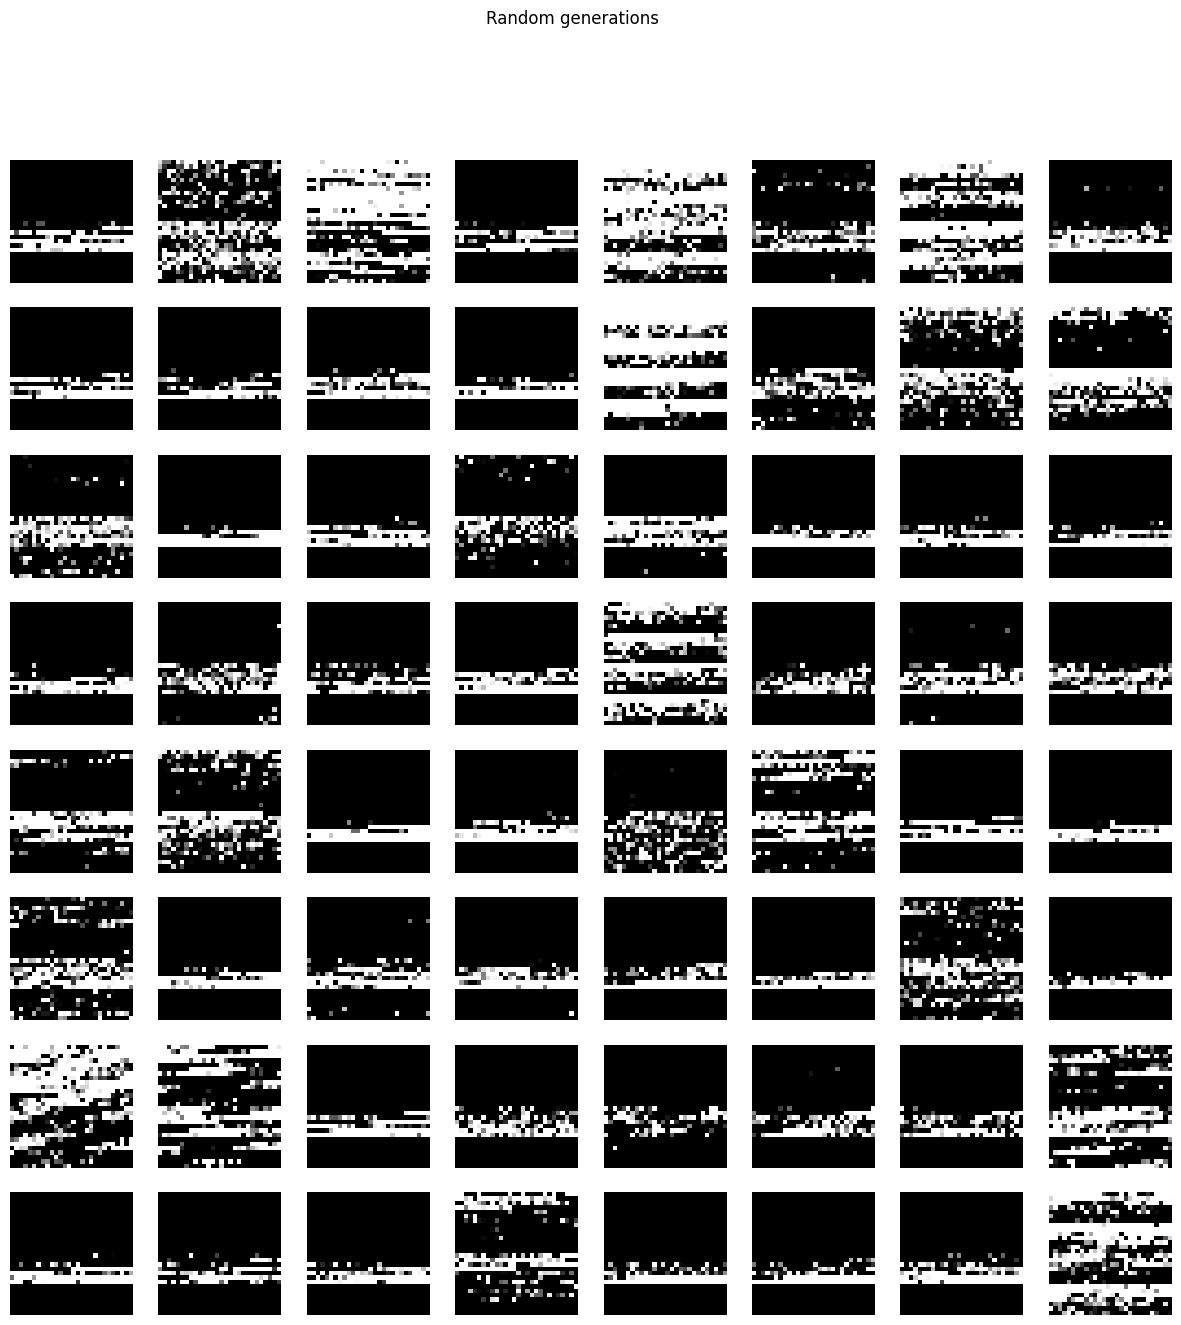

Epoch 1/427


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-22-de5d0fe518b5>", line 25, in <cell line: 25>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

All algorithms tried for %dot.19 = f32[256,64]{1,0} dot(f32[256,392]{1,0} %slice.1, f32[392,64]{1,0} %parameter_1.1), lhs_contracting_dims={1}, rhs_contracting_dims={0}, metadata={op_type="MatMul" op_name="nice_3/sequential_19/dense_44/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160} failed. Falling back to default algorithm.  Per-algorithm errors:
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_83164]

In [ ]:

# Image generation callback
class ImageGenCallback(tf.keras.callbacks.Callback):
    def __init__(self, frequency, **kwargs):
        super().__init__(**kwargs)
        self.frequency = frequency

    def on_epoch_begin(self, epoch, logs=None):
        if not epoch % self.frequency:
            noise = base_distribution.sample(64)
            generated_batch = model.backward(noise).numpy()

            plt.figure(figsize=(15, 15))
            for ind, image in enumerate(generated_batch):
                plt.subplot(8, 8, ind + 1)
                plt.imshow(image.reshape((28, 28)), vmin=0, vmax=1, cmap="Greys_r")
                plt.axis("off")
            plt.suptitle("Random generations")
            plt.show()

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_negative_log_likelihood", patience=20,
                                             restore_best_weights=True, verbose=1)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, monitor="val_negative_log_likelihood", patience=5,
                                                verbose=1)

history = model.fit(train_data, epochs=n_epochs, validation_data=test_data,
                    callbacks=[ImageGenCallback(10), earlystop, reducelr])


In [ ]:
plt.plot(history.history["negative_log_likelihood"], label="training nll")
plt.plot(history.history["val_negative_log_likelihood"], label="validation nll")
plt.legend()
plt.show()

MNIST TRY 2

In [ ]:

# Define the layer factory
def layer_factory():
    return tf.keras.Sequential([
        tfkl.Dense(512),
        tfkl.LayerNormalization(),
        tfkl.LeakyReLU(alpha=0.01),
        tfkl.Dense(512),
        tfkl.LayerNormalization(),
        tfkl.LeakyReLU(alpha=0.01),
        tfkl.Dense(n_v // 2)
    ])

# Number of coupling layers
num_coupling_layers = 6
model = Nice(num_coupling_layers, layer_factory, base_distribution, scale=True)

# Define optimizer
lr_fn = 0.001
optimizer_mnist = tf.optimizers.Adam(lr_fn)

model.compile(optimizer=optimizer_mnist, jit_compile=True)

# Build the model to ensure scaler is created
model.build((None, n_v))


Backward pass input shape: (64, 784)
After scaling backward pass shape: (64, 784)
After layer 6 backward pass shape: (64, 784)
After layer 5 backward pass shape: (64, 784)
After layer 4 backward pass shape: (64, 784)
After layer 3 backward pass shape: (64, 784)


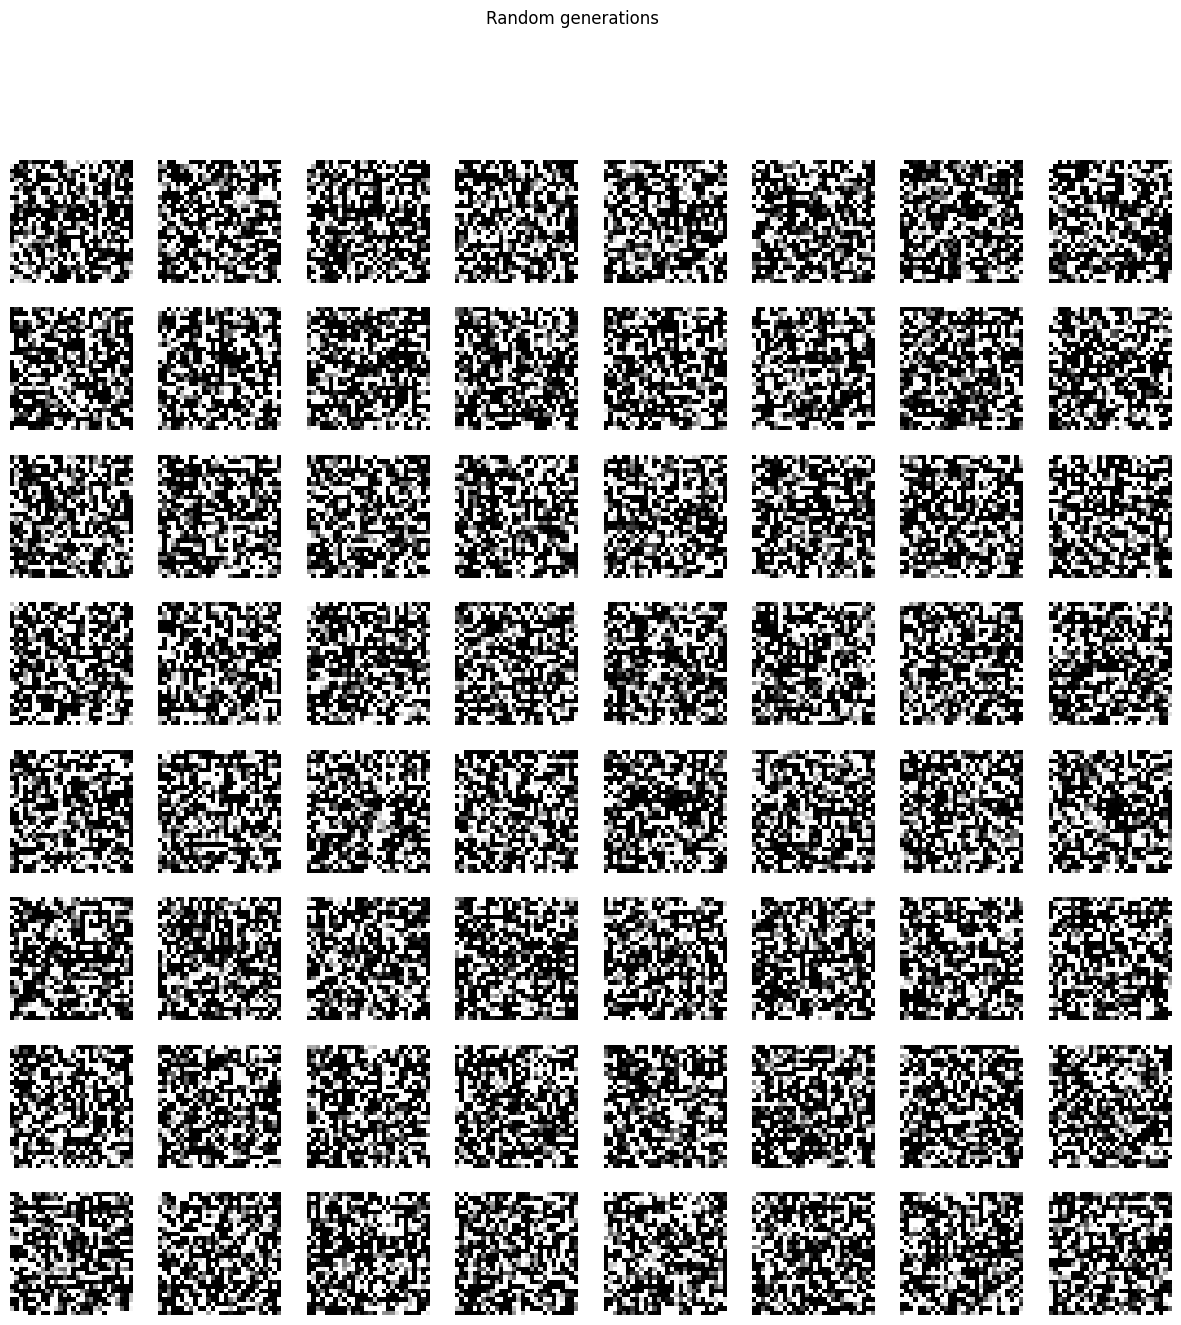

Epoch 1/427
Forward pass input shape: (256, 784)
After layer 1 forward pass shape: (256, 784)
After layer 2 forward pass shape: (256, 784)
After layer 3 forward pass shape: (256, 784)
After layer 4 forward pass shape: (256, 784)
After layer 5 forward pass shape: (256, 784)
After layer 6 forward pass shape: (256, 784)
After scaling forward pass shape: (256, 784)
Log probability shape: (256,)
Forward pass input shape: (256, 784)
After layer 1 forward pass shape: (256, 784)
After layer 2 forward pass shape: (256, 784)
After layer 3 forward pass shape: (256, 784)
After layer 4 forward pass shape: (256, 784)
After layer 5 forward pass shape: (256, 784)
After layer 6 forward pass shape: (256, 784)
After scaling forward pass shape: (256, 784)
Log probability shape: (256,)


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-31-de5d0fe518b5>", line 25, in <cell line: 25>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

All algorithms tried for %dot.12 = f32[392,512]{1,0} dot(f32[256,392]{1,0} %slice.12, f32[256,512]{1,0} %parameter_1.12), lhs_contracting_dims={0}, rhs_contracting_dims={0}, metadata={op_type="MatMul" op_name="gradient_tape/nice_7/sequential_42/dense_102/MatMul/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160} failed. Falling back to default algorithm.  Per-algorithm errors:
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_126009]

In [ ]:

# Image generation callback
class ImageGenCallback(tf.keras.callbacks.Callback):
    def __init__(self, frequency, **kwargs):
        super().__init__(**kwargs)
        self.frequency = frequency

    def on_epoch_begin(self, epoch, logs=None):
        if not epoch % self.frequency:
            noise = base_distribution.sample(64)
            generated_batch = model.backward(noise).numpy()

            plt.figure(figsize=(15, 15))
            for ind, image in enumerate(generated_batch):
                plt.subplot(8, 8, ind + 1)
                plt.imshow(image.reshape((28, 28)), vmin=0, vmax=1, cmap="Greys_r")
                plt.axis("off")
            plt.suptitle("Random generations")
            plt.show()

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_negative_log_likelihood", patience=20,
                                             restore_best_weights=True, verbose=1)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, monitor="val_negative_log_likelihood", patience=5,
                                                verbose=1)

history = model.fit(train_data, epochs=n_epochs, validation_data=test_data,
                    callbacks=[ImageGenCallback(10), earlystop, reducelr])


In [ ]:
plt.plot(history.history["negative_log_likelihood"], label="training nll")
plt.plot(history.history["val_negative_log_likelihood"], label="validation nll")
plt.legend()
plt.show()